In [400]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from load_results import *
from plotting_utils import *
from scipy.stats import pearsonr
import math
import re

In [401]:
plot_pilot_results = False
plot_needs_citation = True
plot_auto_eval_results = False
model_type = 'gpt4'

datasets = ['NQ', 'Eta3G', 'MH', 'MASH']
label_datasets = ['NQ', 'Eta3G', '2WikiMH', 'MASH']
ops = ['Snippet', 'Quoted', 'Paraphrased', 'Entailed', 'Abstractive']
op_names = ['Extractive', 'Quoted', 'Paraphrased', 'Entailed', 'Abstractive']    
all_ops = ['Snippet', 'Quoted', 'Quoted Reeval', 'Paraphrased', 'Entailed', 'Abstractive']
if model_type == 'gpt4':
    ops.extend(['Post Hoc', 'Gemini'])
    op_names.extend(['GPT-4 + Vertex\nAbstractive', 'Gemini'])
    all_ops.extend(['Post Hoc', 'Gemini'])
colors = ['b', 'g', 'r', 'c']
if (plot_pilot_results):
    results_tag = 'Pilot'
    all_results_df, results = load_all_pilot_results()
elif not plot_auto_eval_results:
    if (plot_needs_citation):
        results_tag = 'sentences_that_need_citation_only'
    else: 
        results_tag = 'all_sentences'
    all_results_df, results = load_all_mturk_results(needs_citation_only=plot_needs_citation)
else:
    results_tag = 'auto_eval_'+model_type
    results_tag = results_tag.replace('.', '')
    all_results_df, results = load_all_auto_eval_results(model_type, baselines=True)

In [402]:
len(results['NQ'])/5

196.6

# Avg number of citations per sentence for each OP instantiation

In [403]:
for op in ops[1:]:
    curr_results = all_results_df[all_results_df['op']==op]
    num_citations = 0
    num_cited_sentences = 0
    for i in range(len(curr_results)):
        precision_results = eval(curr_results['precise_citations'].iloc[i])
        for prec_element in precision_results:
            num_citations += len(prec_element['annotations']) 
            if (len(prec_element['annotations'])  > 0):
                num_cited_sentences += 1
    print(op, num_citations/num_cited_sentences)

Quoted 1.186046511627907
Paraphrased 1.3346709470304976
Entailed 1.8964143426294822
Abstractive 1.7475490196078431
Post Hoc 3.1443661971830985
Gemini 1.0


# Fluency and Utility
## In aggregate

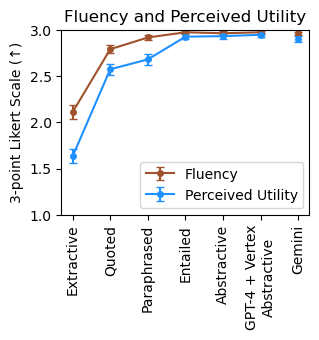

[([1.6334745762711864, 2.575, 2.68125, 2.9270833333333335, 2.933333333333333, 2.9479166666666665, 2.902083333333333], [0.07408133181548522, 0.060807675640832066, 0.05637786518679277, 0.027251687544442987, 0.025809088000710894, 0.02301352026393462, 0.031767180833774424])]

[([2.11228813559322, 2.7916666666666665, 2.91875, 2.975, 2.964583333333333, 2.975, 2.964583333333333], [0.07631694292443664, 0.043866309094028215, 0.026437361962110696, 0.013981720843490718, 0.01934512357059251, 0.015129618580305497, 0.018461228705621714])]


In [404]:
# Plot Utility and Fluency in aggregate
utilities = [get_avg_fluency_or_utility_by_op(all_results_df, 'human_utility_rating', ops)]
fluencies = [get_avg_fluency_or_utility_by_op(all_results_df, 'human_fluency_rating', ops)]

results_labels = datasets

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
def plot_utility_or_fluency(results_list, results_labels, fig, ax1, colors):    
    # Plot the first set of results
    lines, labels = ax1.get_legend_handles_labels()
    for idx, nested_tuple in enumerate(zip(results_list, results_labels)):
        result_label = nested_tuple[1]
        averages = nested_tuple[0][0]
        conf_intervals = nested_tuple[0][1]
        marker = 'o'
        if 'Gemini' in op_names:
            ax1.errorbar(op_names[:-1], averages[:-1], yerr=conf_intervals[:-1], fmt=marker + '-', color=colors[idx], label=result_label, capsize=3, ms=4)
            ax1.errorbar(op_names[-1], averages[-1], yerr=conf_intervals[-1], fmt=marker + '-', color=colors[idx], capsize=3, ms=4)
        else:
            ax1.errorbar(op_names, averages, yerr=conf_intervals, fmt=marker + '-', color=colors[idx], label=result_label, capsize=3, ms=4)
        ax1.set_ylim([1,3])
    plt.xticks(rotation=90)
    return fig, ax1

fig, ax1 = plot_utility_or_fluency(fluencies, ['Fluency'], fig, ax1, colors=['sienna'])
fig, ax1 = plot_utility_or_fluency(utilities, ['Perceived Utility'], fig, ax1, colors=['dodgerblue'])
    
# Set labels and title
ax1.set_ylabel('3-point Likert Scale (↑)')

# set the legend
lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(.29,0))

if (plot_pilot_results):
    plt.title('Pilot Fluency and Perceived Utility')
elif (plot_auto_eval_results):
    plt.title('Auto-eval Fluency and Perceived Utility ('+model_type.upper()+')')
else:
    plt.title('Fluency and Perceived Utility')


plt.savefig('figures/utility_fluency_aggregate_'+results_tag, bbox_inches='tight', dpi=400)
# Show the plot
plt.show()
print(utilities)
print()
print(fluencies)

In [405]:
print('Percent increase in utility from Extractive to GPT-4 + Vertex:', 100*(utilities[0][0][-2]-utilities[0][0][0])/(utilities[0][0][0]-1))

Percent increase in utility from Extractive to GPT-4 + Vertex: 207.49721293199553


## By dataset
### Utility

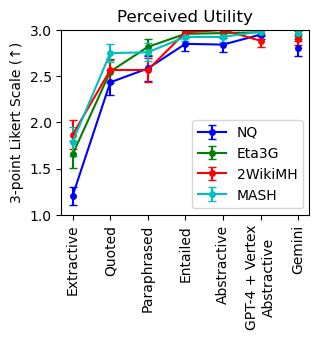

In [406]:
fluencies_or_utilities = []
for dataset in datasets:
    curr_fluency_or_utility = get_avg_fluency_or_utility_by_op(results[dataset], 'human_utility_rating', ops)
    fluencies_or_utilities.append(curr_fluency_or_utility)

results_list = fluencies_or_utilities
results_labels = datasets

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])

# Colors and markers
plot_utility_or_fluency(fluencies_or_utilities, label_datasets, fig, ax1, colors)

# Set labels and title
ax1.set_ylabel('3-point Likert Scale (↑)')

# set the legend
lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(.5,0))

if (plot_pilot_results):
    plt.title('Pilot Perceived Utility')
elif (plot_auto_eval_results):
    plt.title('Auto-eval Perceived Utility ('+model_type.upper()+')')
else:
    plt.title('Perceived Utility')
plt.savefig('figures/utility_by_qd_'+results_tag, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()

### Fluency

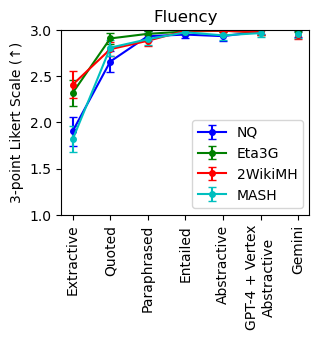

In [407]:
fluencies_or_utilities = []
for dataset in datasets:
    curr_fluency_or_utility = get_avg_fluency_or_utility_by_op(results[dataset], 'human_fluency_rating', ops)
    fluencies_or_utilities.append(curr_fluency_or_utility)

results_list = fluencies_or_utilities
results_labels = datasets

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])

# Colors and markers
colors = ['b', 'g', 'r', 'c']
plot_utility_or_fluency(fluencies_or_utilities, label_datasets, fig, ax1, colors)

# Set labels and title
ax1.set_ylabel('3-point Likert Scale (↑)')

# set the legend
lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(.5,0))

if (plot_pilot_results):
    plt.title('Pilot Fluency')
elif (plot_auto_eval_results):
    plt.title('Auto-eval Fluency ('+model_type.upper()+')')
else:
    plt.title('Fluency')
plt.savefig('figures/fluency_by_qd_'+results_tag, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()

# Precision and Coverage
## In aggregate

[([1, 0.9901140684410646, 0.9670658682634731, 0.9705240174672489, 0.9600798403193613, 0.8196392785571143, 0.8290816326530612], [0, 0.005349458271970674, 0.009573408161951485, 0.010959299943063642, 0.012127990351111943, 0.019483754005299114, 0.037313046339182414])]
[([1, 0.9029688631426502, 0.8881987577639752, 0.8518041237113402, 0.7618522601984564, 0.43369565217391304, 0.14988978692138133], [0, 0.015617390711765053, 0.017216512933237678, 0.02501457616273789, 0.027736431476529978, 0.032041718291201844, 0.01897187502637722])]


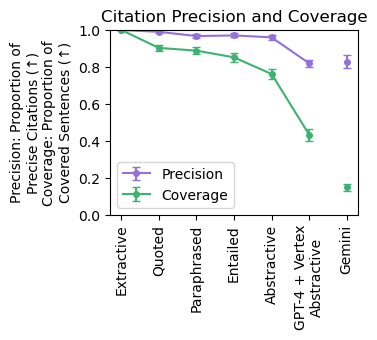

In [408]:
precisions = [get_avg_precision_by_op(all_results_df, ops[1:])]
coverages = [get_avg_coverage_by_op(all_results_df, ops[1:])]

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
print(precisions)
print(coverages)
fig, ax1 = plot_utility_or_fluency(precisions, ['Precision'], fig, ax1, colors=['mediumpurple'])
fig, ax1 = plot_utility_or_fluency(coverages, ['Coverage'], fig, ax1, colors=['mediumseagreen'])
    
# Set labels and title
ax1.set_ylabel('Precision: Proportion of\nPrecise Citations (↑)\nCoverage: Proportion of\nCovered Sentences (↑)')

if (plot_pilot_results):
    plt.title('Pilot Citation\nPrecision and Coverage')
elif (plot_auto_eval_results):
    plt.title('Auto-eval Citation Precision and Coverage ('+model_type.upper()+')')
else:
    plt.title('Citation Precision and Coverage')

plt.ylim(0,1)

# set the legend
lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(0,0))

plt.savefig('figures/precision_coverage_aggregate_'+results_tag, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()

In [409]:
print('Percent decrease in coverage from Extractive to GPT-4 + Vertex:', 100*(coverages[0][0][0]-coverages[0][0][-2])/(coverages[0][0][0]))

Percent decrease in coverage from Extractive to GPT-4 + Vertex: 56.630434782608695


In [410]:
print('Percent decrease in coverage from Extractive to Entailed:', 100*(coverages[0][0][0]-coverages[0][0][-4])/(coverages[0][0][0]))

Percent decrease in coverage from Extractive to Entailed: 14.819587628865982


In [411]:
print('Percent decrease in coverage between Entailed and Gemini:', 100*(coverages[0][0][3]-coverages[0][0][-1])/(coverages[0][0][3]))

Percent decrease in coverage between Entailed and Gemini: 82.40325648245205


In [412]:
print('Percent decrease in precision between Entailed and Gemini:', 100*(precisions[0][0][3]-precisions[0][0][-1])/(precisions[0][0][3]))

Percent decrease in precision between Entailed and Gemini: 14.573816028098529


## By dataset
### Precision

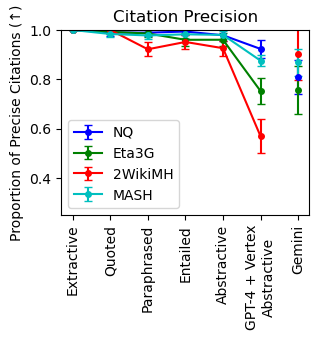

In [413]:
precisions = []
for dataset in datasets:
    precisions.append(get_avg_precision_by_op(results[dataset], ops[1:]))

results_list = precisions
results_labels = datasets

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])

# Colors and markers
colors = ['b', 'g', 'r', 'c']
plot_utility_or_fluency(precisions, label_datasets, fig, ax1, colors)

lines, labels = ax1.get_legend_handles_labels()
# Set labels and title
ax1.set_ylabel('Proportion of Precise Citations (↑)')

if (plot_pilot_results):
    plt.title('Pilot Citation Precision')
elif (plot_auto_eval_results):
    plt.title('Auto-eval Citation Precision ('+model_type.upper()+')')
else:
    plt.title('Citation Precision')

plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(0,0))
plt.ylim(.25, 1)
plt.savefig('figures/precision_by_qd_'+results_tag, bbox_inches='tight', dpi=400)
# Show the plot
plt.show()

### Coverage

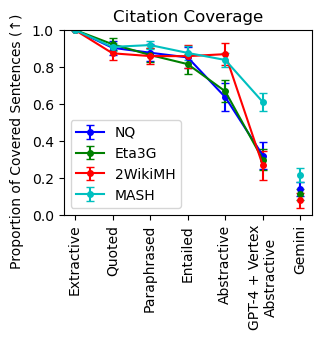

[([1, 0.9036697247706422, 0.8770053475935828, 0.8516129032258064, 0.6363636363636364, 0.32075471698113206, 0.13924050632911392], [0, 0.039256580879582954, 0.047200199552512916, 0.05614549258087245, 0.07622486896501247, 0.07278256708547183, 0.038231778563042336]), ([1, 0.9227941176470589, 0.8645833333333334, 0.8151658767772512, 0.6680161943319838, 0.2987551867219917, 0.11], [0, 0.03177964415522249, 0.03958718423715633, 0.05250014412654386, 0.05884918637533401, 0.057908592386853246, 0.030701597192580043]), ([1, 0.8737541528239202, 0.8587786259541985, 0.8583333333333333, 0.8692307692307693, 0.26666666666666666, 0.07738095238095238], [0, 0.03758362108690389, 0.04224999359588316, 0.0626533673831219, 0.05818104887298872, 0.07945434830172789, 0.04052528514226161]), ([1, 0.9084745762711864, 0.9183303085299456, 0.8758620689655172, 0.8377659574468085, 0.61, 0.21593291404612158], [0, 0.023287651168708158, 0.022887831264323054, 0.038016949050301924, 0.037314084180446405, 0.04785935535229076, 0.036

In [414]:
precisions = []
for dataset in datasets:
    precisions.append(get_avg_coverage_by_op(results[dataset], ops[1:]))

results_list = precisions
results_labels = datasets
# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
# Colors and markers
colors = ['b', 'g', 'r', 'c']
plot_utility_or_fluency(precisions, label_datasets, fig, ax1, colors)

lines, labels = ax1.get_legend_handles_labels()
# Set labels and title
ax1.set_ylabel('Proportion of Covered Sentences (↑)')
ax1.yaxis.set_label_coords(-0.16,.4, transform=None)
if (plot_pilot_results):
    plt.title('Pilot Citation Coverage')
elif (plot_auto_eval_results):
    plt.title('Auto-eval Citation Coverage ('+model_type.upper()+')')
else:
    plt.title('Citation Coverage')

plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(0,0))
plt.ylim(0, 1)
plt.savefig('figures/coverage_by_qd_'+results_tag, bbox_inches='tight', dpi=400)
# Show the plot
plt.show()
print(precisions)
print(label_datasets)

# T2V

[([1.0, 1.4148340100350179, 1.6710357030583618, 1.789683960245353, 2.988290475949321, 2.28446786056097], [0.058427758910249136, 0.07544294255644059, 0.117646647282552, 0.1564111825656297, 0.25180992237350874, 0.19712437877097447])]
['Quoted', 'Paraphrased', 'Entailed', 'Abstractive', 'GPT-4 + Vertex\nAbstractive']
[1.0, 1.4148340100350179, 1.6710357030583618, 1.789683960245353, 2.988290475949321]


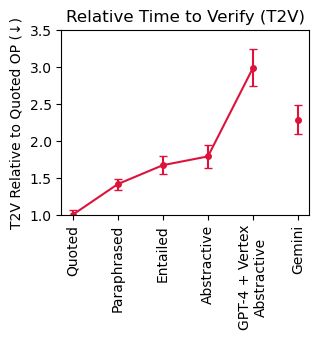

In [415]:
t2vs = []
if (plot_auto_eval_results):
    all_results_df['annotator_id'] = 0

op_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted')
new_avgs = op_t2vs[0][1:5]
new_errors = op_t2vs[1][1:5]
if (plot_pilot_results or (model_type == 'gpt4' and plot_auto_eval_results)):
    quoted_normalization_col = 'Quoted'
else:
    quoted_normalization_col = 'Quoted Reeval'
baseline_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], quoted_normalization_col)
new_avgs.extend(baseline_t2vs[0][-2:])
new_errors.extend(baseline_t2vs[1][-2:])
t2v = (new_avgs, new_errors)
t2vs.append(t2v)

def plot_t2v(results_list, results_labels, fig, ax1, colors):    
    # Plot the first set of results
    lines, labels = ax1.get_legend_handles_labels()
    for idx, nested_tuple in enumerate(zip(results_list, results_labels)):
        result_label = nested_tuple[1]
        averages = nested_tuple[0][0]
        conf_intervals = nested_tuple[0][1]
        marker = 'o'
        if 'Gemini' in op_names:
            print(op_names[1:-1])
            print(averages[:-1])
            ax1.errorbar(op_names[1:-1], averages[:-1], yerr=conf_intervals[:-1], fmt=marker + '-', color=colors[idx], label=result_label, capsize=3, ms=4)
            ax1.errorbar('Gemini', averages[-1], yerr=conf_intervals[-1], fmt=marker + '-', color=colors[idx], capsize=3, ms=4)
        else:
            ax1.errorbar(op_names[1:], averages[:-2], yerr=conf_intervals[:-2], fmt=marker + '-', color=colors[idx], label=result_label, capsize=3, ms=4)
        ax1.set_ylim([1,3])
    plt.xticks(rotation=90)
    return fig, ax1
print(t2vs)
# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
fig, ax1 = plot_t2v(t2vs, ['T2V'], fig, ax1, colors=['crimson'])


# Set labels and title
ax1.set_ylabel('T2V Relative to Quoted OP (↓)')
# ax1.set_xlabel('\nA') # if saving the appendix version

if (plot_pilot_results):
    plt.title('Pilot Relative Time to Verify (T2V)')
elif (plot_auto_eval_results):
    plt.title('Relative Time to Verify (T2V) ('+model_type.upper()+')')
else:
    plt.title('Relative Time to Verify (T2V)')
    
plt.ylim(1,3.5)

plt.savefig('figures/t2v_aggregate_'+results_tag, bbox_inches='tight', dpi=400)
# plt.savefig('figures/t2v_aggregate_appendix_'+results_tag, bbox_inches='tight', dpi=400)


# Show the plot
plt.show()

In [416]:
print('GPT-4 + Vertex has this many times higher T2V than Quoted:', t2vs[0][0][-2])

GPT-4 + Vertex has this many times higher T2V than Quoted: 2.988290475949321


/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theod

[([1.0, 1.4797318300014057, 1.496732026372273, 2.107765528111028, 3.2796578648505665, 2.6678617165587677], [0.09670360553192088, 0.16934006010035232, 0.18385592538863363, 0.3758042808537618, 0.49183480892375536, 0.33367128359799064]), ([1.0, 1.5887120038231357, 1.7017714225339535, 1.8137643906130052, 3.456037434109524, 2.058724814298558], [0.09875123278302281, 0.15461001992329784, 0.24107026613070037, 0.32462212524424555, 0.5660530044328814, 0.329954463037017]), ([1.0, 1.6441666667634407, 1.9834680754952396, 2.190382317476617, 3.6153139021583485, 2.560541159167988], [0.11675976049709189, 0.2235755422353721, 0.3380125861250357, 0.5200657974148926, 0.854519750806497, 0.5519641931579166]), ([1.0, 1.272162682923897, 1.710854300180425, 1.714797266742078, 2.8484996866824845, 2.0417389639492307], [0.07738093163808701, 0.08990629359766383, 0.18704165705012088, 0.1694135026236401, 0.29503330216031487, 0.33523412798007857])]
['Quoted', 'Paraphrased', 'Entailed', 'Abstractive', 'GPT-4 + Vertex\nA

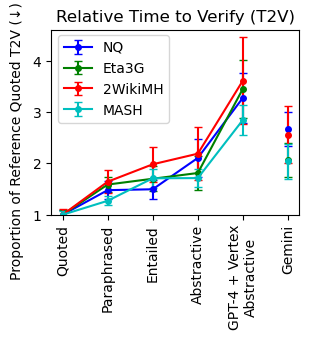

In [417]:
t2vs = []
for dataset in datasets:
    if (plot_auto_eval_results):
        results[dataset]['annotator_id'] = 0
    op_t2vs = get_relative_t2v_by_op(results[dataset], ops[1:], 'Quoted')
    new_avgs = op_t2vs[0][1:5]
    new_errors = op_t2vs[1][1:5]
    baseline_t2vs = get_relative_t2v_by_op(results[dataset], ops[1:], 'Quoted Reeval')
    new_avgs.extend(baseline_t2vs[0][-2:])
    new_errors.extend(baseline_t2vs[1][-2:])
    t2v = (new_avgs, new_errors)
    t2vs.append(t2v)

results_list = t2vs
results_labels = datasets
print(t2vs)
# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
fig, ax1 = plot_t2v(t2vs, label_datasets, fig, ax1, colors)
    
plt.ylim(1,4.6)


# Set labels and title
ax1.set_ylabel('Proportion of Reference Quoted T2V (↓)')
ax1.yaxis.set_label_coords(-0.11,.4, transform=None)
if (plot_pilot_results):
    plt.title('Pilot Relative Time to Verify (T2V)')
elif (plot_auto_eval_results):
    plt.title('Relative Time to Verify (T2V) ('+model_type.upper()+')')
else:
    plt.title('Relative Time to Verify (T2V)')

lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(0,.46))
plt.savefig('figures/t2v_by_qd_'+results_tag, bbox_inches='tight', dpi=400)
# Show the plot
plt.show()

## T2V Median Values

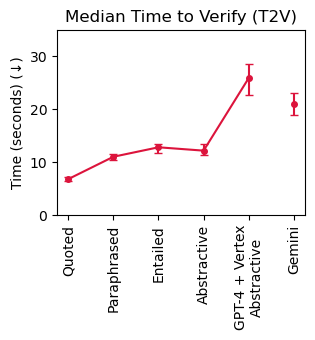

In [418]:
op_t2vs = get_median_t2v_by_op(all_results_df, ops[1:], normalized=False, remove_outliers=False, coverage_value=-1)
new_avgs = op_t2vs[0][1:7]
new_errors = op_t2vs[1][:,1:7]
t2vs = (new_avgs, new_errors)

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
lines, labels = ax1.get_legend_handles_labels()
if 'Gemini' in op_names:
    ax1.errorbar(op_names[1:-1], t2vs[0][:-1], yerr=[t2vs[1][0][:-1],t2vs[1][1][:-1]], fmt='o-', color='crimson', label='T2V', capsize=3, ms=4)
    ax1.errorbar('Gemini', t2vs[0][-1:], yerr=[t2vs[1][0][-1:],t2vs[1][0][-1:]], fmt='o-', color='crimson', capsize=3, ms=4)
else:
    ax1.errorbar(op_names[1:], t2vs[0], yerr=t2vs[1], fmt='o-', color='crimson', label='T2V', capsize=3, ms=4)
ax1.set_ylim([0,35])
plt.xticks(rotation=90)

# Set labels and title
ax1.set_ylabel('Time (seconds) (↓)')

if (plot_pilot_results):
    plt.title('Pilot Median Time to Verify (T2V)')
else:
    plt.title('Median Time to Verify (T2V)')

plt.savefig('figures/t2v_median_'+results_tag, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()

## T2V Average Values

([12.667928542158602, 17.728752962173708, 21.105236884761364, 21.842515160847295, 37.62435740664997, 29.477828444875016], [1.1035833495618184, 1.1507686573330407, 1.9299143912874075, 2.0478082122673813, 3.079795560340135, 2.808706380314257])


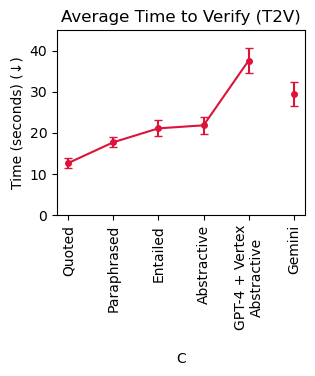

In [419]:
op_t2vs = get_avg_t2v_by_op(all_results_df, ops[1:], normalized=False, remove_outliers=False, coverage_value=-1)
new_avgs = op_t2vs[0][1:7]
new_errors = op_t2vs[1][1:7]
t2vs = (new_avgs, new_errors)

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
lines, labels = ax1.get_legend_handles_labels()
if 'Gemini' in op_names:
    ax1.errorbar(op_names[1:-1], t2vs[0][:-1], yerr=t2vs[1][:-1], fmt='o-', color='crimson', label='T2V', capsize=3, ms=4)
    ax1.errorbar('Gemini', t2vs[0][-1:], yerr=t2vs[1][-1:], fmt='o-', color='crimson', capsize=3, ms=4)
else:
    ax1.errorbar(op_names[1:], t2vs[0], yerr=t2vs[1], fmt='o-', color='crimson', label='T2V', capsize=3, ms=4)
ax1.set_ylim([0,45])
plt.xticks(rotation=90)

# Set labels and title
ax1.set_xlabel('\nC')
ax1.set_ylabel('Time (seconds) (↓)')

if (plot_pilot_results):
    plt.title('Pilot Average Time to Verify (T2V)')
else:
    plt.title('Average Time to Verify (T2V)')

plt.savefig('figures/t2v_average_'+results_tag, bbox_inches='tight', dpi=400)
print(t2vs)
plt.show()

# T2V for correctly covered sentences

In [420]:
all_results_df, results = load_all_mturk_results(needs_citation_only=True)

/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[([1.0, 1.351097414357922, 1.5813207834999392, 1.6791775204387684, 2.641569853542366, 1.9582457048840916], [0.059019557694535686, 0.07329449121941535, 0.12121717187554146, 0.17238479266261367, 0.22107912642244248, 0.24428490245407347])]


/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


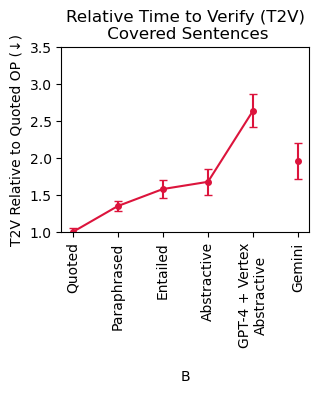

In [421]:
t2vs = []
op_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted', coverage_value=1)
new_avgs = op_t2vs[0][1:5]
new_errors = op_t2vs[1][1:5]
baseline_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted Reeval', coverage_value=1)
new_avgs.extend(baseline_t2vs[0][-2:])
new_errors.extend(baseline_t2vs[1][-2:])
t2v = (new_avgs, new_errors)
t2vs.append(t2v)

def plot_t2v(results_list, results_labels, fig, ax1, colors):    
    # Plot the first set of results
    lines, labels = ax1.get_legend_handles_labels()
    for idx, nested_tuple in enumerate(zip(results_list, results_labels)):
        result_label = nested_tuple[1]
        averages = nested_tuple[0][0]
        conf_intervals = nested_tuple[0][1]
        marker = 'o'
        if 'Gemini' in op_names:
            ax1.errorbar(op_names[1:-1], averages[:-1], yerr=conf_intervals[:-1], fmt=marker + '-', color=colors[idx], label=result_label, capsize=3, ms=4)
            ax1.errorbar('Gemini', averages[-1], yerr=conf_intervals[-1], fmt=marker + '-', color=colors[idx], capsize=3, ms=4)
        else:
            print(averages)
            ax1.errorbar(op_names[1:-2], averages, yerr=conf_intervals[:-2], fmt=marker + '-', color=colors[idx], label=result_label, capsize=3, ms=4)
        ax1.set_ylim([1,3])
    plt.xticks(rotation=90)
    return fig, ax1
print(t2vs)
# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
fig, ax1 = plot_t2v(t2vs, ['T2V'], fig, ax1, colors=['crimson'])
    
# Set labels and title
ax1.set_xlabel('\nB')
ax1.set_ylabel('T2V Relative to Quoted OP (↓)')

plt.title('Relative Time to Verify (T2V)\n Covered Sentences')
plt.ylim(1,3.5)

# no legend

plt.savefig('figures/t2v_aggregate_covered_only_'+results_tag, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()

In [422]:
def t2v_and_coverage_consistency(all_results_df, tag=''):
    for i in range(len(all_results_df)):
        if (all_results_df['op'].iloc[i] == 'Snippet'):
            continue
        coverage = eval(all_results_df['is_covered'].iloc[i])
        t2v = eval(all_results_df['t2v_coverage'].iloc[i])
        num_nonneg_cov = len([x for x in coverage if x['coverage']!=-1])
        if (len(t2v) != num_nonneg_cov):
            print(tag)
            print('num T2V annotations', len(t2v))
            print('num coverage annotations', len(coverage))
            print('T2V annotations', t2v)
            print('Coverage annotations', coverage)
            print()
t2v_and_coverage_consistency(all_results_df)

# T2V over full responses

[([1.0000000000000002, 1.4920386647648043, 1.0823097240740682, 1.2614156792075584, 2.009389848448843, 1.842778081651897], [0.0869451033512649, 0.14395663836965006, 0.09173287702485258, 0.13619289191241138, 0.24816581130867307, 0.346538777572964])]


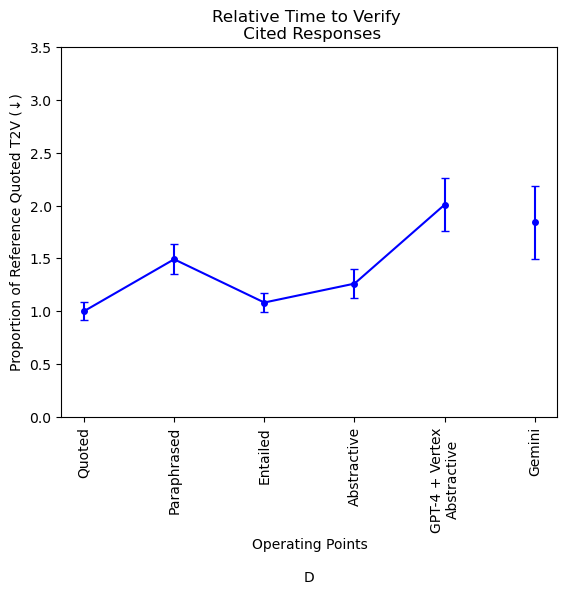

In [423]:
fig, ax1 = plt.subplots()

t2vs = []
op_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted', over_response=True, coverage_value=1)
new_avgs = op_t2vs[0][1:5]
new_errors = op_t2vs[1][1:5]
baseline_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted Reeval', over_response=True, coverage_value=1)
new_avgs.extend(baseline_t2vs[0][-2:])
new_errors.extend(baseline_t2vs[1][-2:])
t2v = (new_avgs, new_errors)
t2vs.append(t2v)

def plot_t2v(results_list, results_labels, fig, ax1, num_sentences, colors):    
    # Plot the first set of results
    lines, labels = ax1.get_legend_handles_labels()
    for idx, nested_tuple in enumerate(zip(results_list, results_labels)):
        result_label = nested_tuple[1]
        averages = nested_tuple[0][0]
        conf_intervals = nested_tuple[0][1]
        marker = 'o'
        ax1.errorbar(op_names[1:-1], averages[:-1], yerr=conf_intervals[:-1], fmt=marker + '-', color=colors[num_sentences-1], capsize=3, ms=4)
        ax1.errorbar('Gemini', averages[-1], yerr=conf_intervals[-1], fmt=marker + '-', color=colors[num_sentences-1], capsize=3, ms=4)
        ax1.set_ylim([0,2.5])
    plt.xticks(rotation=90)
    return fig, ax1
print(t2vs)

fig, ax1 = plot_t2v(t2vs, ['T2V'], fig, ax1, 1, colors=colors)
    
# Set labels and title
ax1.set_xlabel('Operating Points\n\nD')
ax1.set_ylabel('Proportion of Reference Quoted T2V (↓)')

plt.title('Relative Time to Verify \n Cited Responses')
plt.ylim(0,3.5)

plt.savefig('figures/t2v_aggregate_entire_response_by_sentence_'+results_tag, bbox_inches='tight', dpi=400)

plt.show()

### Evaluate relative T2V over entire responses QD

/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


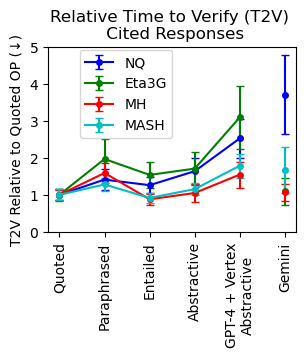

In [424]:
def plot_t2v(results_list, results_labels, fig, ax1, num_sentences, colors, label):    
            # Plot the first set of results
            lines, labels = ax1.get_legend_handles_labels()
            for idx, nested_tuple in enumerate(zip(results_list, results_labels)):
                result_label = nested_tuple[1]
                averages = nested_tuple[0][0]
                conf_intervals = nested_tuple[0][1]
                marker = 'o'
                ax1.errorbar(op_names[1:-1], averages[:-1], yerr=conf_intervals[:-1], fmt=marker + '-', color=colors[num_sentences-1], capsize=3, ms=4, label=label)
                ax1.errorbar('Gemini', averages[-1], yerr=conf_intervals[-1], fmt=marker + '-', color=colors[num_sentences-1], capsize=3, ms=4)
                ax1.set_ylim([0,5])
            return fig, ax1
data_i = 0
fig, ax1 = plt.subplots(figsize=(3.2, 2.4))
for i in range(2):
    for j in range(2):
        
        data_str = datasets[data_i]
        data_i += 1
        curr_colors = [colors[data_i-1]]
        t2vs = []
        op_t2vs = get_relative_t2v_by_op(results[data_str], ops[1:], 'Quoted', over_response=True, coverage_value=1)
        new_avgs = op_t2vs[0][1:5]
        new_errors = op_t2vs[1][1:5]
        baseline_t2vs = get_relative_t2v_by_op(results[data_str], ops[1:], 'Quoted Reeval', over_response=True, coverage_value=1)
        new_avgs.extend(baseline_t2vs[0][-2:])
        new_errors.extend(baseline_t2vs[1][-2:])
        t2v = (new_avgs, new_errors)
        t2vs.append(t2v)
        
        # Initialize the plot
        fig, ax1 = plot_t2v(t2vs, ['T2V'], fig, ax1, 1, colors=curr_colors, label=data_str)
            
        # Set labels and title
        ax1.set_ylabel('T2V Relative to Quoted OP (↓)')
        
        plt.title('Relative Time to Verify (T2V) \n Cited Responses')
        plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(.1, .47))
plt.savefig('figures/t2v_all_qd_entire_covered_response_'+results_tag, bbox_inches='tight', dpi=400)
plt.show()


# Average Quote Length

In [425]:
def count_quoted_words_and_quotes(quoted_output):
    quotes = re.findall(r'"(.*?)"', quoted_output)
    quoted_words = [len(q.split(' ')) for q in quotes]
    quoted_characters = [len(q) for q in quotes]
    total_words = len(quoted_output.split(' '))
    return quoted_words, quoted_characters, len(quotes), total_words

In [426]:
quoted_outputs = all_results_df[all_results_df['op']=='Quoted']['Output (cited)']
total_quoted_words = []
total_quoted_characters = []
total_words = 0
n_quotes = 0
for i in range(len(quoted_outputs)):
    curr_total_quoted_words, curr_total_quoted_characters, curr_n_quotes, curr_total_words = count_quoted_words_and_quotes(quoted_outputs.iloc[i])
    total_quoted_words += curr_total_quoted_words # appending to a list
    n_quotes += curr_n_quotes # adding to a sum
    total_quoted_characters += curr_total_quoted_characters # appending to a list
    total_words += curr_total_words # appending to a list

In [427]:
print(np.sum(total_quoted_words)/n_quotes, 'words')

14.5438919582566 words


In [428]:
print(np.sum(total_quoted_characters)/n_quotes, 'characters')

84.64333947206876 characters


In [429]:
print(np.sum(total_quoted_words)/total_words*100,'% quoted')

81.74165056582943 % quoted


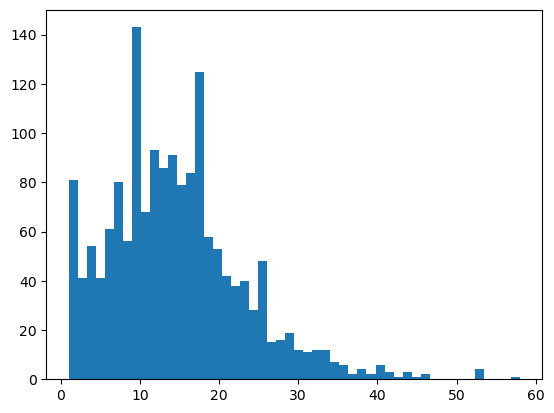

In [430]:
plt.hist(total_quoted_words, 50);

# Avg output length in words by OP

In [431]:
def clean_highlight_markers_from_snippets(df):
    df = df.copy()
    for i in range(len(df)):
        response = df['Output'].iloc[i]
        colors = {'\\x1b[92m':':green[', '\\x1b[96m':':orange[', '\\x1b[95m':':red[', '\\x1b[1;31;60m':':blue[', '\\x1b[102m':':violet[', '\x1b[1;35;40m':':grey[', '\\x1b[0;30;47m':':rainbow[', '\\x1b[0;33;47m':':orange[', '\\x1b[0;34;47m':':blue[', '\\x1b[0;31;47m':':red[', '\\x1b[0m':']'}
        for highlight_marker in colors.keys():
            response_ls = response.split(highlight_marker)
            response = ''.join(response_ls)
        df.loc[i, 'Output'] = response
    return df

In [432]:
for op in ops:
    op_results_df = all_results_df[all_results_df['op']==op]
    if (op=='Snippet'):
        op_results_df = clean_highlight_markers_from_snippets(op_results_df)
    
    output_lengths = op_results_df['Output'].str.split().apply(len)
    print(op+':', np.mean(output_lengths))

Snippet: 235.75833333333333
Quoted: 56.985416666666666
Paraphrased: 60.15625
Entailed: 32.72291666666667
Abstractive: 38.475
Post Hoc: 34.49166666666667
Gemini: 47.829166666666666


# Calculate AI-Human Agreement Rates

In [433]:
model_type = 'gpt4'

# Load auto-eval results
results_tag = 'auto_eval_'+model_type
results_tag = results_tag.replace('.', '')
all_auto_eval_results_df, auto_eval_results = load_all_auto_eval_results(model_type, baselines=True)

# Load human results
results_tag = 'sentences_that_need_citation_only'
all_human_results_df, human_results = load_all_mturk_results(needs_citation_only=True)

# Merge auto-eval and human results
all_ae_andh_results = pd.merge(all_auto_eval_results_df, all_human_results_df, on=['query_id', 'dataset', 'op'], suffixes=('_AE', '_H'))


In [434]:
# Helper function to get agreement statistics

def get_disaggregated_agreement_stats(human_annotations, ae_annotations, labels=[0,1]):
    assert len(human_annotations) == len(ae_annotations)
    # Get agreement
    human_annotations = np.array(human_annotations)
    ae_annotations = np.array(ae_annotations) 
    print("Mean agreement:", np.mean(human_annotations == ae_annotations))

    # Get confusion matrix
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(human_annotations, ae_annotations, labels=labels)
    print(conf_matrix)

    # Get correlations
    correlation, p_value = pearsonr(human_annotations, ae_annotations)
    print("Disaggregated Pearson correlation:", correlation)

def get_aggregated_correlation(human_annotation_df, ae_annotation_df, column):
    a = human_annotation_df.groupby(by=['op'])[column].agg('mean')
    b = ae_annotation_df.groupby(by=['op'])[column].agg('mean')
    annotation_df = pd.merge(a, b, on='op', suffixes=('_H', '_AE'))
    correlation, p_value = pearsonr(annotation_df[column+'_H'], annotation_df[column+'_AE'])
    print(f"{column}: Aggregated Pearson correlation: {correlation}         p-value: {p_value}")

    plt.figure()
    plt.scatter(annotation_df[column+'_H'], annotation_df[column+'_AE'])
    plt.xlabel('Human '+column)
    plt.ylabel('Auto-eval '+column)
    plt.title(f'{column} Pearson Correlation Coefficient: {correlation:.2f}')
    for i, row in annotation_df.iterrows():
        plt.annotate(row.name, (row[column+'_H'], row[column+'_AE']))

    if column in ['human_fluency_rating', 'human_utility_rating']:
        plt.xlim(1, 3)
        plt.ylim(1, 3)
    else:
        plt.xlim(np.min(annotation_df[column+'_H'])-0.1, 1)
        plt.ylim(np.min(annotation_df[column+'_AE'])-0.1, 1)
    plt.show()

    return correlation, p_value, annotation_df[column+'_H'], annotation_df[column+'_AE']


def convert_to_indexed_dict(annotation_ls):
    indexed_dict = {}
    annotation_key = ''
    if not annotation_ls:
        return indexed_dict
    for y in annotation_ls[0].keys():
        if y != 'sentence_id':
            annotation_key = y

    for x in annotation_ls:
        indexed_dict[x['sentence_id']] = x[annotation_key]
    return indexed_dict

In [435]:
# Fluency
# get_disaggregated_agreement_stats(all_ae_andh_results['human_fluency_rating_H'], all_ae_andh_results['human_fluency_rating_AE'], labels=[1,2,3])

In [436]:
# Perceived Utility
# get_disaggregated_agreement_stats(all_ae_andh_results['human_utility_rating_H'], all_ae_andh_results['human_utility_rating_AE'], labels=[1,2,3])

In [437]:
# Citation Coverage
ae_coverage_annotations = []
human_coverage_annotations = []
coverage_op_ls = []

for i in range(len(all_ae_andh_results)):
    if all_ae_andh_results['op'].iloc[i] == "Snippet":
        continue
    curr_op = all_ae_andh_results['op'].iloc[i]
    ae_coverage = eval(all_ae_andh_results['is_covered_AE'].iloc[i])
    ae_coverage = convert_to_indexed_dict(ae_coverage)
    human_coverage = eval(all_ae_andh_results['is_covered_H'].iloc[i])
    human_coverage = convert_to_indexed_dict(human_coverage)

    for sentence_id in human_coverage.keys():
        if str(sentence_id) not in ae_coverage:
            continue
        h_x = int(human_coverage[sentence_id])
        ae_x = int(ae_coverage[str(sentence_id)])
        if (h_x != -1) and (ae_x != -1):
            ae_coverage_annotations.append(ae_x)
            human_coverage_annotations.append(h_x)
            coverage_op_ls.append(curr_op)

# get_disaggregated_agreement_stats(human_coverage_annotations, ae_coverage_annotations)

In [438]:
# Citation Precision
ae_precision_annotations = []
human_precision_annotations = []
precision_op_ls = []

for i in range(len(all_ae_andh_results)):
    if all_ae_andh_results['op'].iloc[i] == "Snippet":
        continue
    curr_op = all_ae_andh_results['op'].iloc[i]
    ae_precision = eval(all_ae_andh_results['precise_citations_AE'].iloc[i])
    ae_precision = convert_to_indexed_dict(ae_precision)
    human_precision = eval(all_ae_andh_results['precise_citations_H'].iloc[i])
    human_precision = convert_to_indexed_dict(human_precision)
    
    for sentence_id in human_precision.keys():
        if str(sentence_id) not in ae_precision:
            continue
        h_x = human_precision[sentence_id]
        ae_x = ae_precision[str(sentence_id)]
        if len(h_x) != len(ae_x):
            continue
        
        ae_precision_annotations.extend(ae_x)
        human_precision_annotations.extend(h_x)
        precision_op_ls.extend([curr_op]*len(h_x))

# get_disaggregated_agreement_stats(human_precision_annotations, ae_precision_annotations)

In [439]:
from itertools import permutations

def permutation_pvalue(x, y):
    observed_r = pearsonr(x, y)[0]
    simulated_r_samples = []
    for y_permuted in permutations(y):
        r_perm = pearsonr(x, y_permuted)[0]
        simulated_r_samples.append(r_perm)
    
    # Get the percentile of the observed correlation in the null distribution
    simulated_r_samples = np.array(simulated_r_samples)
    p_value = (np.sum(simulated_r_samples >= observed_r) + 1) / (len(simulated_r_samples) + 1) # finite sample correction
    print("Permutation p-value:", p_value)
    return p_value

human_fluency_rating: Aggregated Pearson correlation: 0.9617154933949678         p-value: 0.0005395672907348408


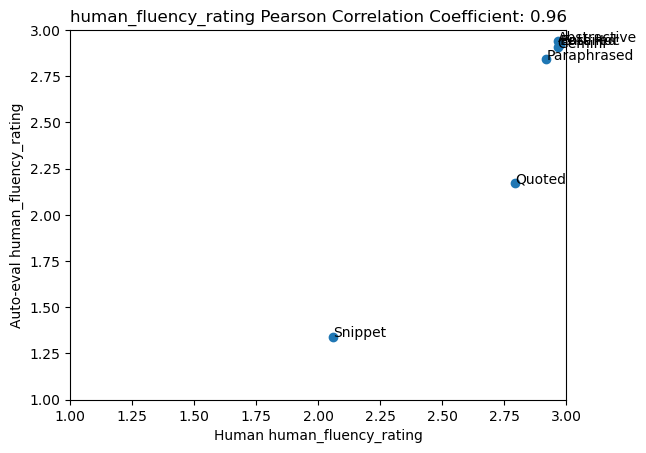

Permutation p-value: 0.0033723467565959135
human_utility_rating: Aggregated Pearson correlation: 0.9652022522347128         p-value: 0.0004257819796175436


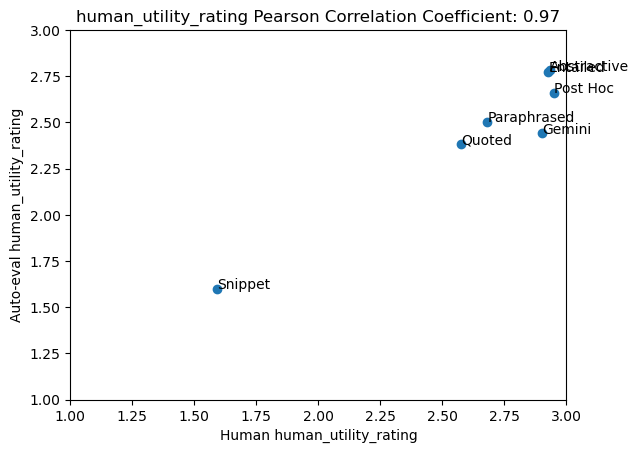

Permutation p-value: 0.009521920253917874
coverage: Aggregated Pearson correlation: 0.9766063268095196         p-value: 0.000814494661071348


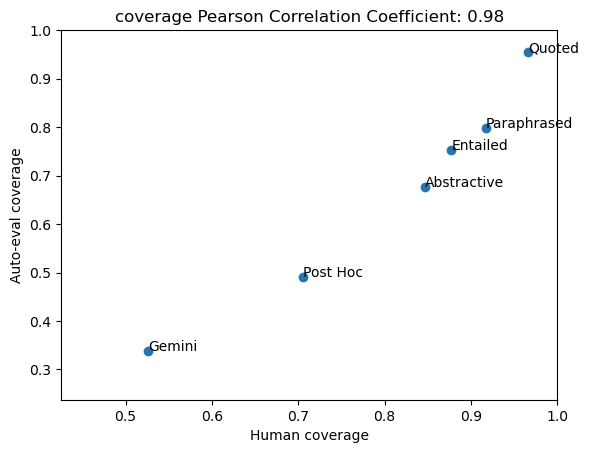

Permutation p-value: 0.0027739251040221915
precision: Aggregated Pearson correlation: 0.9488990633814073         p-value: 0.003850238500817167


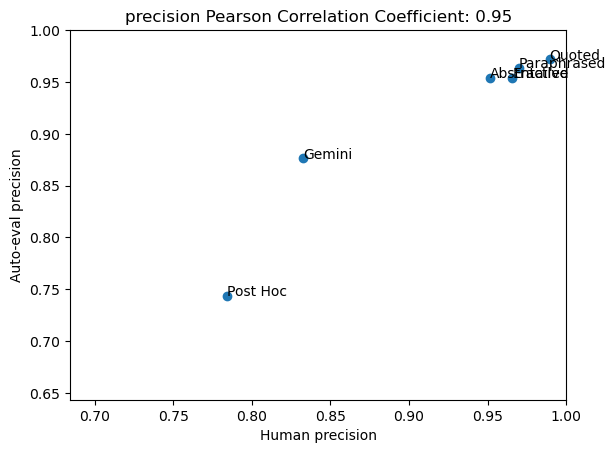

Permutation p-value: 0.004160887656033287


In [440]:
r_ls = []
p_val_ls = []
metric_name_ls = []

r, _, h_means, ae_means = get_aggregated_correlation(all_human_results_df, all_auto_eval_results_df, "human_fluency_rating")
p_value = permutation_pvalue(h_means, ae_means)
r_ls.append(r)
p_val_ls.append(p_value)
metric_name_ls.append("Fluency")

r, _, h_means, ae_means = get_aggregated_correlation(all_human_results_df, all_auto_eval_results_df, "human_utility_rating")
p_value = permutation_pvalue(h_means, ae_means)
r_ls.append(r)
p_val_ls.append(p_value)
metric_name_ls.append("Utility")

human_temp_df = pd.DataFrame({'coverage': human_coverage_annotations, 'op': coverage_op_ls})
ae_temp_df = pd.DataFrame({'coverage': ae_coverage_annotations, 'op': coverage_op_ls})
r, _, h_means, ae_means = get_aggregated_correlation(human_temp_df, ae_temp_df, column='coverage')
p_value = permutation_pvalue(h_means, ae_means)
r_ls.append(r)
p_val_ls.append(p_value)
metric_name_ls.append("Coverage")

human_temp_df = pd.DataFrame({'precision': human_precision_annotations, 'op': precision_op_ls})
ae_temp_df = pd.DataFrame({'precision': ae_precision_annotations, 'op': precision_op_ls})
r, _, h_means, ae_means = get_aggregated_correlation(human_temp_df, ae_temp_df, column='precision')
p_value = permutation_pvalue(h_means, ae_means)
r_ls.append(r)
p_val_ls.append(p_value)
metric_name_ls.append("Precision")

In [441]:
# Build dataframe
df = pd.DataFrame({
    "Metric": metric_name_ls,
    "Correlation (r)": r_ls,
    "p-value": p_val_ls
})


latex_table = df.to_latex(
    index=False,
    escape=False,
    bold_rows=False,
    column_format="lrr",
    caption="Correlations Between Human and Automated Metrics",
    label="tab:correlations",
    longtable=False,
    float_format="%.3f",   # default for everything else
    # formatters={
    #     "p-value": lambda x: f"{x:.1e}"  # scientific notation
    # }
)

print(latex_table)

\begin{table}
\caption{Correlations Between Human and Automated Metrics}
\label{tab:correlations}
\begin{tabular}{lrr}
\toprule
Metric & Correlation (r) & p-value \\
\midrule
Fluency & 0.962 & 0.003 \\
Utility & 0.965 & 0.010 \\
Coverage & 0.977 & 0.003 \\
Precision & 0.949 & 0.004 \\
\bottomrule
\end{tabular}
\end{table}



# Inter-annotator Agreement Rate for Fluency and Perceived Utility

In [442]:
# Read all results
df = pd.read_csv('../mturk_results/processed_results/eta3g_mturk_eval_byQueryOP_ops_all.csv')
df['dataset'] = 'eta3g'
for data_str in ['mash', 'mh', 'nq']:
    temp_df = pd.read_csv(f'../mturk_results/processed_results/{data_str}_mturk_eval_byQueryOP_ops_all.csv')
    temp_df['dataset'] = data_str
    df = pd.concat([df, temp_df], ignore_index=True)    

In [443]:
fluency_interannotator_agreement_rate = np.mean(df['first_human_fluency_rating'] == df['human_fluency_rating'])
print('Fluency inter-annotator agreement rate:', round(fluency_interannotator_agreement_rate, 3))

Fluency inter-annotator agreement rate: 0.766


In [444]:
utility_interannotator_agreement_rate =np.mean(df['first_human_utility_rating'] == df['human_utility_rating'])
print('Utility inter-annotator agreement rate:', round(utility_interannotator_agreement_rate, 3))

Utility inter-annotator agreement rate: 0.702
